<a href="https://colab.research.google.com/github/xitonchong/dcgan_DRIVE/blob/master/drive_cisir2019.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
#https://drive.grand-challenge.org/
!git clone https://github.com/xitonchong/retina_data

fatal: destination path 'retina_data' already exists and is not an empty directory.


'''DESIGN DOC:
--------------------------------
OBJECTIVE:  to demonstrate the capabilities of GAN of synthesizing medical images 
            through unconditional, semi-supervised manner.  (image synthesis)
DL LANGUAGE:  tensorflow 2.0, based on keras
            advantage over tensorflow version 1.x:  prebuild computation graph before execution
OTHER GAN TASK:  
 1.  image segmentation, where given retina image, identify location where lesion is present (if any)
 2.  computer vision task:  style transfer, super-resolution (DLSS), interpolate possible frame in between two successive video frame
GAN is a heuristic learning method where the cost function does not guarantee convergence, 
  As space get larger, GAN might have difficulties in guessing the fake image as generator is conjectured to have harder task of
  synthesizing image that is close to real image without looking at the input image, discriminator has "easier" task as it takes a look
  at both input and fake images.  All generator sees are scalar feedback from discriminator (*and its gradient)
  it is important to check gradient from output is properly backpropagated into front layers if GAN fails.  
  
'''

In [0]:
mkdir -p images


'''from google.colab import files
files.upload()'''

In [44]:
cp ./retina_data/gan.h5 .  && ls

gan.h5			      processed_0.png  processed_5.png	retina_data
images			      processed_1.png  processed_6.png	sample_data
logs			      processed_2.png  processed_7.png
ngrok			      processed_3.png  processed_8.png
ngrok-stable-linux-amd64.zip  processed_4.png  processed_9.png


In [45]:
!pip install matplotlib
!pip install tensorflow==2.0.0beta
!pip install pillow

In [46]:
from PIL import Image
import os
import numpy as np
import glob
import tensorflow as tf
import random
from tensorflow.keras import Model
from tensorflow.keras.layers import Activation, BatchNormalization
from tensorflow.keras.layers import Reshape, Input, Dropout
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Conv2DTranspose
from tensorflow.keras.optimizers import SGD, Adam
import argparse
import math
import matplotlib.pyplot as plt
from IPython.display import Image, display

print(tf.__version__)

2.0.0-beta0


In [47]:
def named_logs(model, logs):
    result = {}
    for l in zip(model.metrics_names, logs):
        result[l[0]] = l[1]
    return result

AUTOTUNE = tf.data.experimental.AUTOTUNE

#data_dir = '/tf/data'
data_dir = './retina_data'
data = os.path.join(data_dir, "*/images/*.jpg")
data_list = glob.glob(data)
print(type(data_list[0]))

#print(len(data_list))
assert len(data_list) == 40
random.shuffle(data_list)

# function ------------------------------------------

def preprocess_image(image):
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [64, 64])
  image /= 255.0  # normalize to [0,1] range

  return image


def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)


def change_range(image):
    # convert from [0,1] to [-1,1]
    return 2*image-1

#==================================================

<class 'str'>


In [48]:
tensorboard = tf.keras.callbacks.TensorBoard(
    log_dir='./logs',
    histogram_freq=0,
    batch_size=10,
    write_graph=True,
    write_grads=True
)


W0822 05:16:23.821462 140438255474560 callbacks.py:1467] `write_grads` will be ignored in TensorFlow 2.0 for the `TensorBoard` Callback.
W0822 05:16:23.825615 140438255474560 callbacks.py:1470] `batch_size` is no longer needed in the `TensorBoard` Callback and will be ignored in TensorFlow 2.0.


In [49]:
#pass each data path to dataset object
path_ds = tf.data.Dataset.from_tensor_slices(data_list)
#print('shape: ', repr(path_ds.output_shapes))
#print('type: ', path_ds.output_types)
print(path_ds)

ds = path_ds.map(load_and_preprocess_image)
BATCH_SIZE=10
ds  = ds.repeat()
ds  = ds.batch(BATCH_SIZE)
# buffer size refers to preload how many data into memory as a balance of speed and memory
# important for shuffling different batches into network
ds  = ds.prefetch(buffer_size=AUTOTUNE) 
keras_ds = ds.map(change_range)


<TensorSliceDataset shapes: (), types: tf.string>


0 (10, 64, 64, 3)
1 (10, 64, 64, 3)
2 (10, 64, 64, 3)
3 (10, 64, 64, 3)
4 (10, 64, 64, 3)
5 (10, 64, 64, 3)
6 (10, 64, 64, 3)
7 (10, 64, 64, 3)
8 (10, 64, 64, 3)
9 (10, 64, 64, 3)


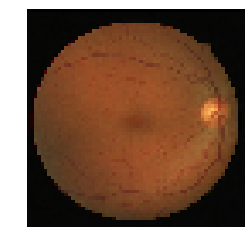

In [50]:
## testing the dataset object output
# having a sanity check on pixel min and max
for i in range(10):
    image = next(iter(keras_ds))
    print(i, image.shape)
    assert np.min(image) >= -1.0
    assert np.max(image) <= 1.0
    #print(np.min(image), np.max(image))
    # convert image to [0 .. 1] range as plt.savefig expects the value
    image = image*0.5 + 0.5
    plt.imshow(image[i,:,:,:])
    plt.axis('off')
    plt.savefig("./processed_%d.png" % i)

./processed_2.png


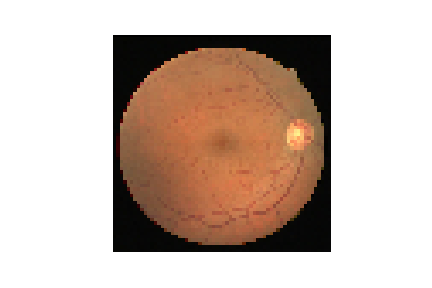

./processed_4.png


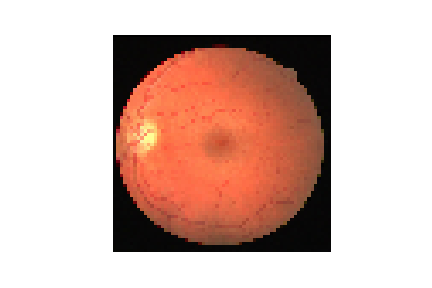

./processed_8.png


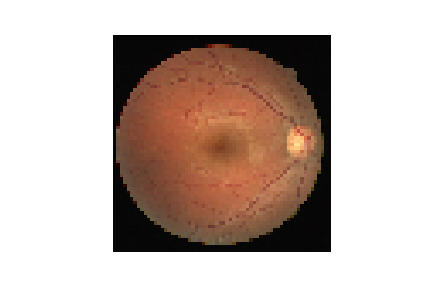

In [51]:
real = ['./processed_2.png', './processed_4.png', './processed_8.png']
# viewing down-resolutioned input images
for imageName in real:
    print(imageName)
    display(Image(filename=imageName))

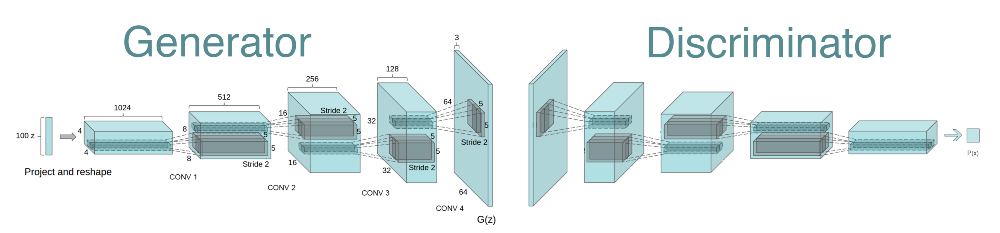

In [52]:
display(Image('./retina_data/dcgan.png'))
# the dimension of this example is differnt than picture below. Serves as reference only.  

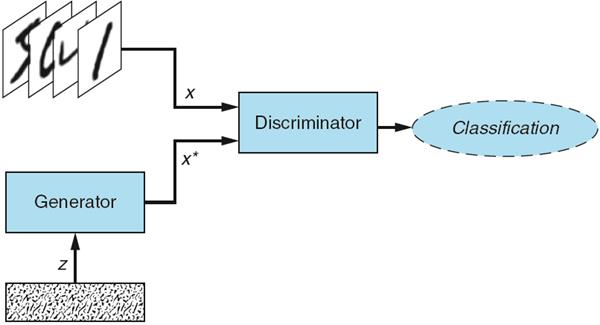

In [53]:
# GAN TRAINING FLOW
display(Image('./retina_data/gan_training.jpg'))

In [0]:
# warpper to conventional function
def conv2d(filters, kernel_size, strides, padding):
    return Conv2D(filters=filters, kernel_size=kernel_size, 
                    strides=strides, padding=padding, 
                    kernel_initializer='he_normal')

def conv2dTranspose(filters, kernel_size, strides, padding):
    return Conv2D(filters=filters, kernel_size=kernel_size,
                    strides=strides, padding=padding, 
                    kernel_initializer='he_normal')


In [0]:
class DCGAN():
    def __init__(self):
        self.height = 64
        self.width  = 64
        self.channel= 3
        self.img_shape=(self.width, self.height, self.channel)
        self.latent_dim = 100
        layer_init = 'he_normal'  #kaiming he initializer

        optimizer = Adam(0.0002, 0.5)
        #optimizer = SGD(lr=0.00005)
        # build models
        self.dis = self._build_discriminator()
        # compile discriminator,  freeze discriminator pipe g to d, 
        self.dis.compile(loss='binary_crossentropy', 
                optimizer=optimizer,
                metrics=['accuracy'])

        # build generator
        self.gen = self._build_generator()
        z = Input(shape=(self.latent_dim,))
        img = self.gen(z)
        # set discriminator before compiling combined network ensures that
        # no gradient is flowing through discriminator
        self.dis.trainable = False
        valid = self.dis(img)

        # combined model
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', 
                    optimizer=optimizer)
        
        # tensorboard attach model
        tensorboard.set_model(self.dis)
        #tensorboard.set_model(self.combined)

    def _build_discriminator(self, padding='same'):
        
        model = tf.keras.Sequential()
        model.add(Conv2D(64, (3,3), strides=(2,2),
                input_shape=(self.height, self.width, self.channel),
                kernel_initializer='he_normal'))
        model.add(Activation('relu'))
        model.add(Dropout(0.25))
        model.add(Conv2D(32, (3,3), strides=(2,2), padding=padding,
            kernel_initializer='he_normal'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dropout(0.25))
        model.add(Conv2D(16, (3,3), strides=(2,2), padding=padding,
            kernel_initializer='he_normal'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1))
        model.add(Activation('sigmoid'))
        
        model.summary()
        x = Input(shape=self.img_shape)
        prob = model(x)
        return Model(x, prob)


    def _build_generator(self, padding='same'):

        model = tf.keras.Sequential()
        model.add(Dense(16*16*64, input_shape=(self.latent_dim,)))
        #model.add(Activation('relu'))
        model.add(Activation('relu'))
        model.add(Reshape((16, 16, 64),  input_shape=(16*16*64,)))
        model.add(Conv2DTranspose(64, kernel_size=(3,3), strides=(2,2),
                padding=padding, kernel_initializer='he_normal'))
        model.add(Activation('relu'))
        model.add(Conv2DTranspose(64, kernel_size=(3,3), strides=(1,1),
                padding=padding, kernel_initializer='he_normal'))
        model.add(Activation('relu'))
        model.add(Conv2DTranspose(32, 
                kernel_size=(3,3), strides=(2,2),
                padding=padding, kernel_initializer='he_normal'))
        model.add(Activation('relu'))
        model.add(Conv2DTranspose(self.channel,
                kernel_size=(3,3), strides=(1,1),
                padding=padding, kernel_initializer='he_normal'))
        model.add(Activation('tanh'))
            
        model.summary()
        noise = Input(shape=(self.latent_dim,))
        img   = model(noise)

        return Model(noise, img)
               
    def train(self, epochs=1000, batch_size=10, save_interval=100):
        
        # adversarial ground trutg
        valid = np.ones((batch_size,1))
        fake = np.zeros((batch_size,1))
        
        for epoch in range(epochs+1):

            imgs = next(iter(keras_ds))
            #--------------------------
            # train discriminator
            #----------------------------
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.gen.predict(noise)

            d_loss_real = self.dis.train_on_batch(imgs, valid)
            d_loss_fake = self.dis.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            #----------------------------
            #  train generator
            #-----------------------------
            g_loss = self.combined.train_on_batch(noise, valid)
            print("%4d [D loss: %4.3f, acc.: %.2f%%] [g loss: %4.3f]" %
                    (epoch, d_loss[0], d_loss[1]*100, g_loss))
            # tensorboard save
            tensorboard.on_epoch_end(epoch, named_logs(self.dis, d_loss))
            #tensorboard.on_epoch_end(epoch, named_logs(self.combined, g_loss))            
            if epoch % save_interval == 0:
                print("== saving images, ", epoch)
                self.save_imgs(epoch)
        #save weights
        gan.combined.save_weights('gan.h5')

    def save_imgs(self, epoch):
        r, c = 5,5
        noise = np.random.normal(0, 1, (r*c, self.latent_dim))
        gen_imgs=  self.gen.predict(noise)

        # rescale images 0-1
        gen_imgs = 0.5*gen_imgs + 0.5

        fig, axs = plt.subplots(r,c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt,:,:,:])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("./images/mnist_%d.png" % epoch)
        plt.close()

    def test_imgs(self, epoch=1001, load=True):
        if load and os.path.exists('gan.h5'):
            self.combined.load_weights('gan.h5')
            self.save_imgs(epoch)
        else:
            print('there is no pretrained weight yet')
            self.train()
            



In [56]:
gan = DCGAN()
gan.test_imgs(1001)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 31, 31, 64)        1792      
_________________________________________________________________
activation_18 (Activation)   (None, 31, 31, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 32)        18464     
_________________________________________________________________
batch_normalization_4 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
activation_19 (Activation)   (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 16, 16, 32)       

W0822 05:16:29.229985 140438255474560 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 05:16:29.235869 140438255474560 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 05:16:29.244863 140438255474560 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 05:16:29.249078 140438255474560 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 05:16:29.257958 140438255474560 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 05:16:29.262500 140438255474560 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0822 05:16:29.268319 140438

testing GAN 

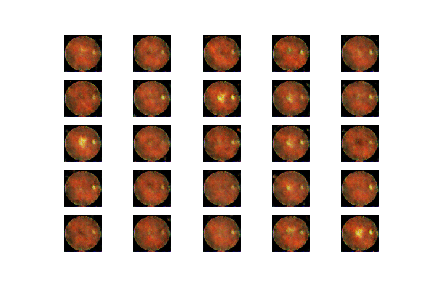

In [57]:
display(Image(filename='./images/mnist_1001.png'))


## to download weights from colab to local drive
from google.colab import files

files.download('gan.h5')

./retina_data/mnist_0.png


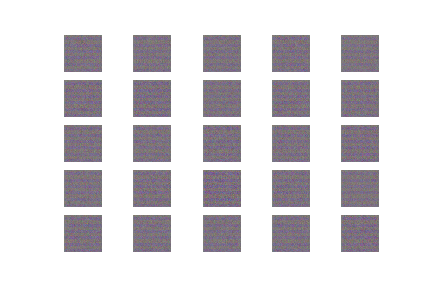

./retina_data/mnist_600.png


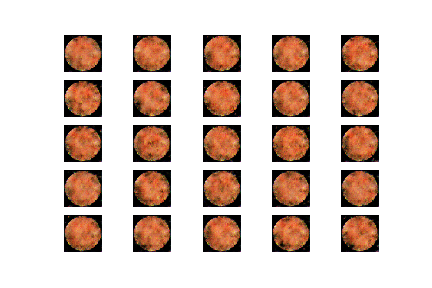

./retina_data/mnist_1000.png


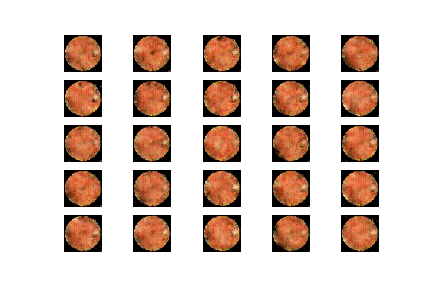

In [58]:
fake = ['./retina_data/mnist_0.png', './retina_data/mnist_600.png', './retina_data/mnist_1000.png']

# viewing fake images produces by GAN
for imageName in fake:
    print(imageName)
    display(Image(filename=imageName))

./processed_2.png


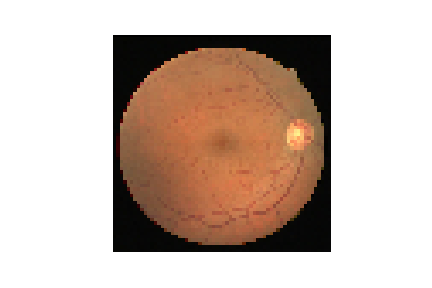

./processed_4.png


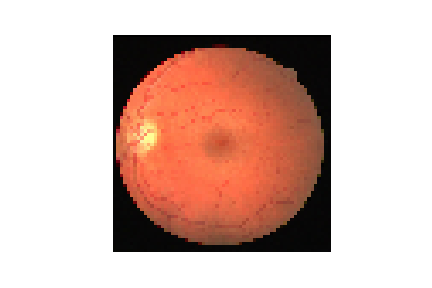

./processed_8.png


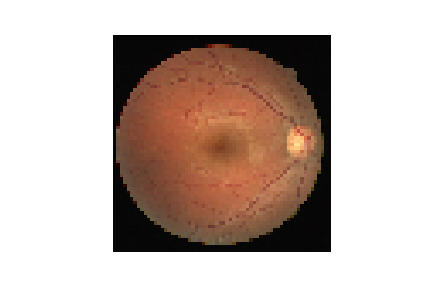

In [59]:
# viewing down-resolutioned input images
for imageName in real:
    print(imageName)
    display(Image(filename=imageName))

## TAKEAWAY:
1.  processing input into tfRecords or tf dataset format
2.  GAN workflow and validate output
3.  Tensorboard directory is located in logs. Run tensorboard --logdir=./logs to see. 

Further improvement:
1.  checkpoint when training and reloading
2.  explore other type, task of GAN

##to view in jupyter notebook

In [60]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip



--2019-08-22 05:16:32--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.72.230.122, 3.219.64.173, 35.170.135.225, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.72.230.122|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13607069 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.1’

ngrok-stable-linux- 100%[===================>]  12.98M  17.1MB/s    in 0.8s    

2019-08-22 05:16:33 (17.1 MB/s) - ‘ngrok-stable-linux-amd64.zip.1’ saved [13607069/13607069]

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ngrok                   


In [0]:
LOG_DIR = './logs'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [0]:
get_ipython().system_raw('./ngrok http 6006 &')

In [63]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://1e8e1552.ngrok.io
